# **Stadium Attendance Prediction**

## **Data Processing**

In [1]:
#Importieren der benötigten Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import pickle
import shap

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path  = "drive/MyDrive/Colab Notebooks/"

In [4]:
df = pd.read_csv(path + "football_results.csv")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 48 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Competition                     981 non-null    object 
 1   Matchday                        981 non-null    object 
 2   Time                            981 non-null    int64  
 3   Home Team                       981 non-null    object 
 4   Ranking Home Team               981 non-null    int64  
 5   Away Team                       981 non-null    object 
 6   Ranking Away Team               981 non-null    int64  
 7   Attendance                      981 non-null    int64  
 8   Weather                         981 non-null    object 
 9   Temperature (°C)                981 non-null    float64
 10  Date                            981 non-null    object 
 11  Weekday                         981 non-null    object 
 12  Month                           981 

In [6]:
df.head(10)

Competition              Matchday  Time       Home Team  \
0                   Super League                     1    20         FC Sion   
1                   Super League                     1    19   FC St. Gallen   
2               Challenge League                     1    17   FC Winterthur   
3                   Super League                     1    16       FC Zürich   
4                   Super League                     1    16  BSC Young Boys   
5  UEFA Europa League Qualifying  Second Round 1st leg    20       FC Luzern   
6               Challenge League                     2    19  Lausanne-Sport   
7                   Super League                     2    19     Servette FC   
8                   Super League                     2    19        FC Basel   
9                   Super League                     2    16       FC Luzern   

   Ranking Home Team      Away Team  Ranking Away Team  Attendance  \
0                  8       FC Basel                  3       11000   
1                  2      FC Luzern                  6       11672   
2                  4       FC Aarau                  8        3800   
3                  7      FC Lugano                  5        9430   
4                  1    Servette FC                  4       25110   
5                  0    KÍ Klaksvík                  0        6344   
6                  4     FC Chiasso                  9        2135   
7                  6        FC Sion                  9       11142   
8                  2  FC St. Gallen                  8       21932   
9                  3      FC Zürich                 10        9917   

                 Weather  Temperature (°C)  ... Day  \
0  Clear or mostly clear              24.6  ...  19   
1          Partly cloudy              24.0  ...  20   
2          Partly cloudy              29.4  ...  20   
3  Clear or mostly clear              26.8  ...  21   
4  Clear or mostly clear              26.0  ...  21   
5          Partly cloudy              26.4  ...  25   
6          Partly cloudy              20.8  ...  27   
7                  Rainy              20.3  ...  27   
8          Partly cloudy              22.4  ...  27   
9                  Rainy              17.7  ...  28   

  Goals Scored in Last 5 Games  Goals Conceded in Last 5 Games  \
0                          4.0                             7.0   
1                          4.0                             7.0   
2                          5.0                             5.0   
3                          5.0                             6.0   
4                         14.0                             1.0   
5                         10.0                             2.0   
6                          8.0                             8.0   
7                         10.0                             3.0   
8                          4.0                             7.0   
9                          1.0                             0.0   

   Number of Wins in Last 5 Games Opposing team Category  Home team Category  \
0                             2.0             Top ranked       Medium ranked   
1                             1.0          Medium ranked          Top ranked   
2                             0.0          Medium ranked       Medium ranked   
3                             1.0          Medium ranked       Medium ranked   
4                             5.0          Medium ranked          Top ranked   
5                             4.0             Not ranked          Not ranked   
6                             1.0          Bottom ranked       Medium ranked   
7                             4.0          Bottom ranked       Medium ranked   
8                             2.0          Medium ranked          Top ranked   
9                             1.0          Bottom ranked          Top ranked   

  Game day  Time slot Weather GoodBad Derby  
0  Weekday      Night            Good     0  
1  Weekend    Evening            Good     1  
2  Weekend  After

In [7]:
# Entfernen aller Daten, die eine Percentage Ateendance > 1 haben
df.loc[df['PercentageAttendance'] > 1, 'PercentageAttendance'] = 1

In [8]:
# Gruppiere nach 'Home Team' und berechne die gewünschten Werte (Perzentile der Attendance)
team_stats = df.groupby('Home Team').agg(
    max_capacity=('Max Capacity', 'first'),  # Nehme die Max Capacity aus der ersten Zeile für jedes Team
    attendance_30th_percentile=('Attendance', lambda x: x.quantile(0.30)),  # 30. Perzentil der Attendance
    attendance_70th_percentile=('Attendance', lambda x: x.quantile(0.70))   # 70. Perzentil der Attendance
).reset_index()

print(team_stats)

         Home Team  max_capacity  attendance_30th_percentile  \
0   BSC Young Boys       31783.0                     25282.1   
1         FC Basel       38512.0                     19527.0   
2        FC Lugano        6330.0                      2843.5   
3        FC Luzern       16800.0                     10105.5   
4          FC Sion       16232.0                      6500.0   
5    FC St. Gallen       20029.0                     15683.8   
6    FC Winterthur        8550.0                      5100.0   
7        FC Zürich       26104.0                     10870.0   
8     Grasshoppers       26104.0                      4049.6   
9   Lausanne-Sport       12544.0                      3773.6   
10     Servette FC       30084.0                      6076.6   
11   Yverdon Sport        6600.0                       712.6   

    attendance_70th_percentile  
0                      31120.0  
1                      22666.5  
2                       3509.6  
3                      13171.9  
4 

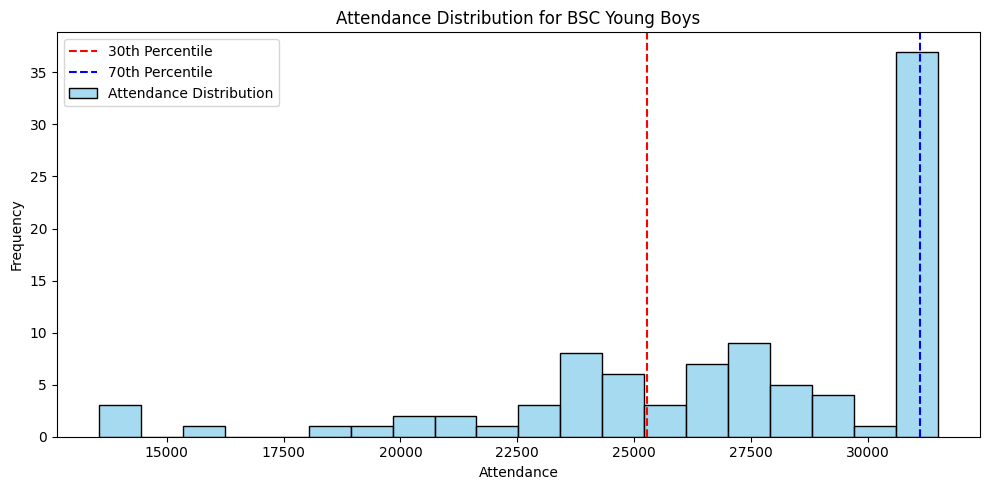

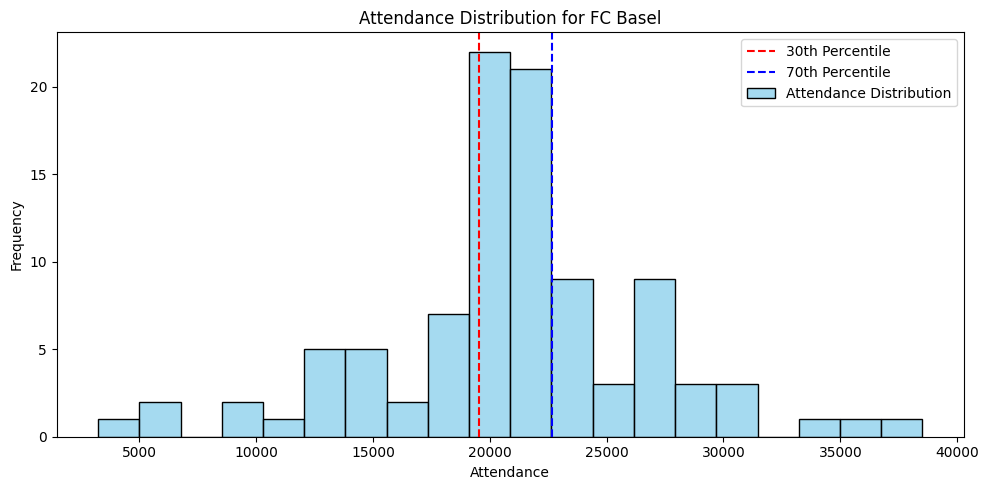

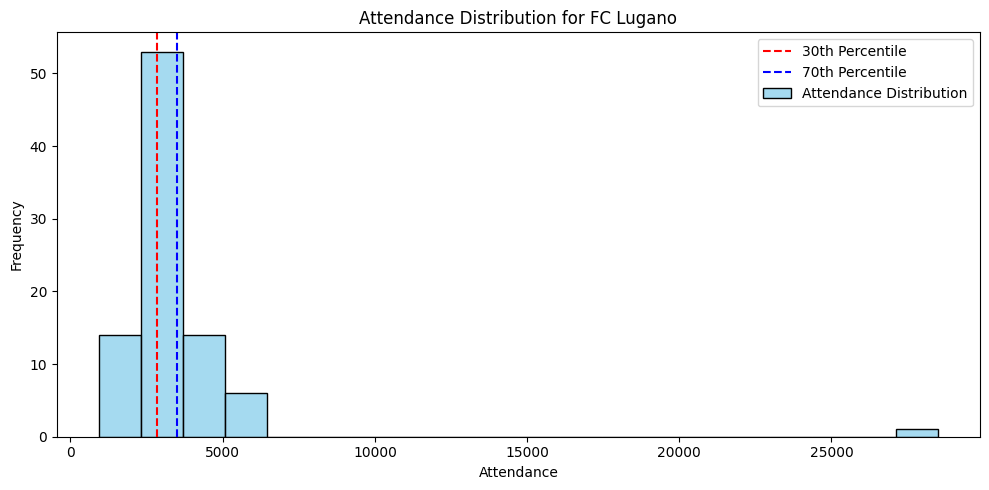

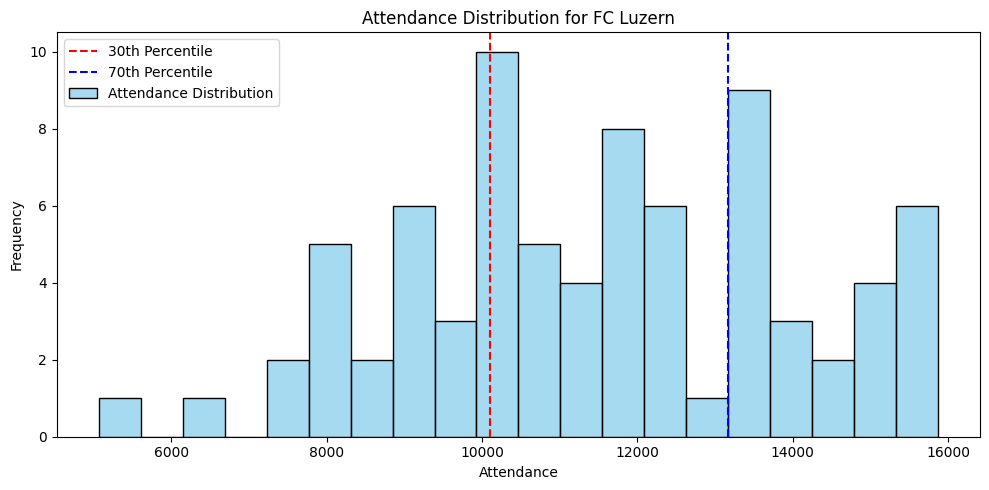

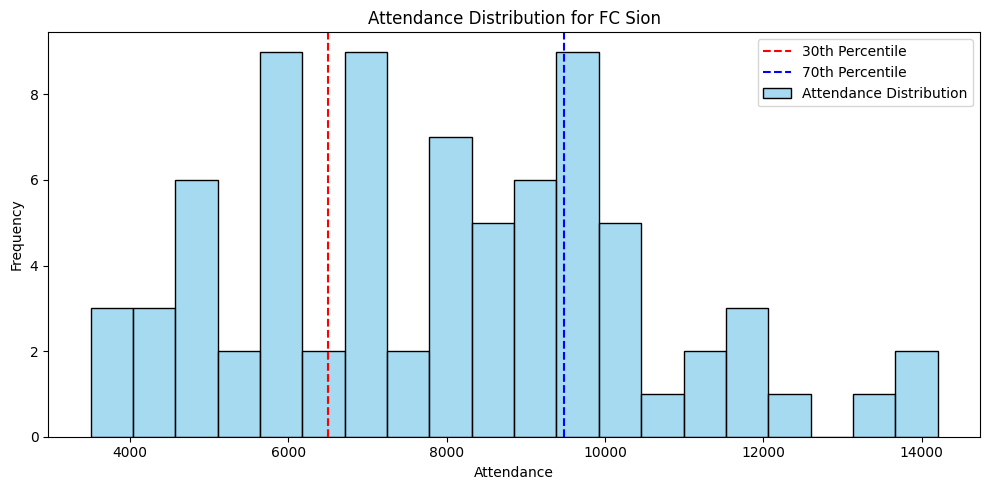

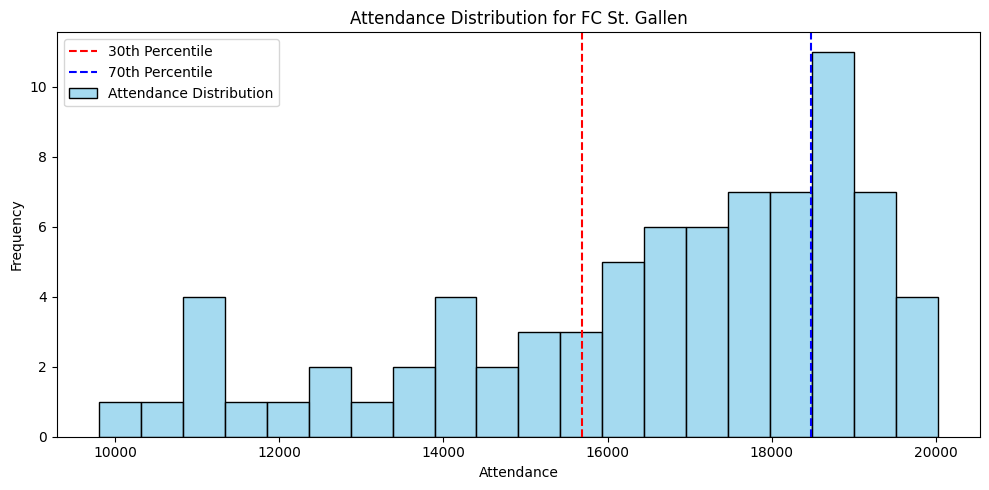

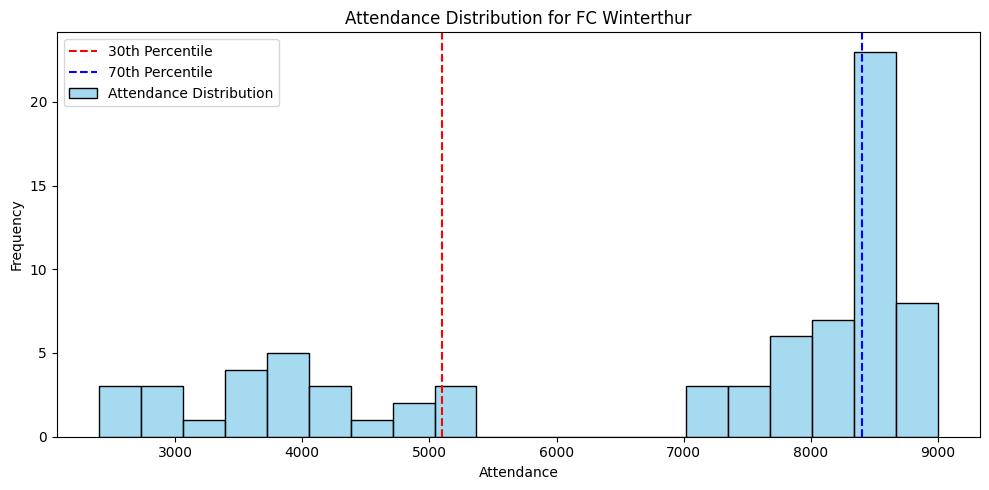

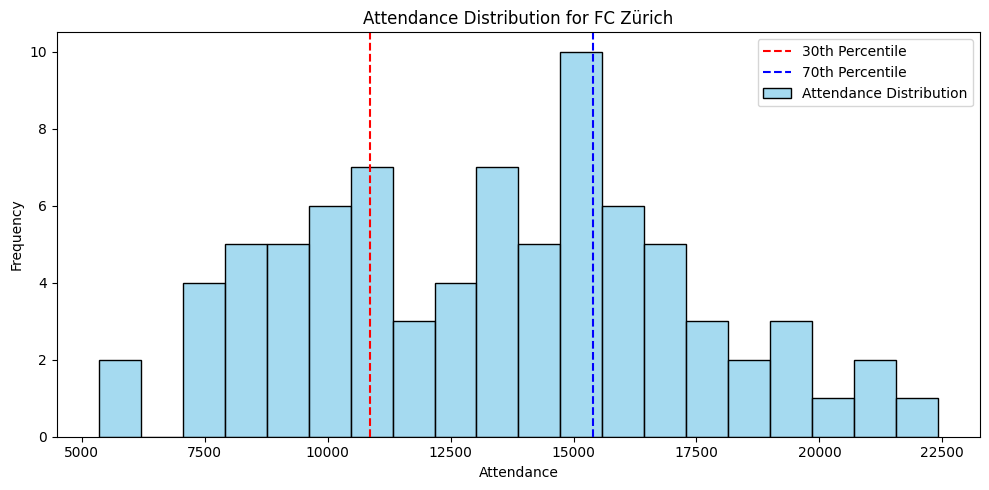

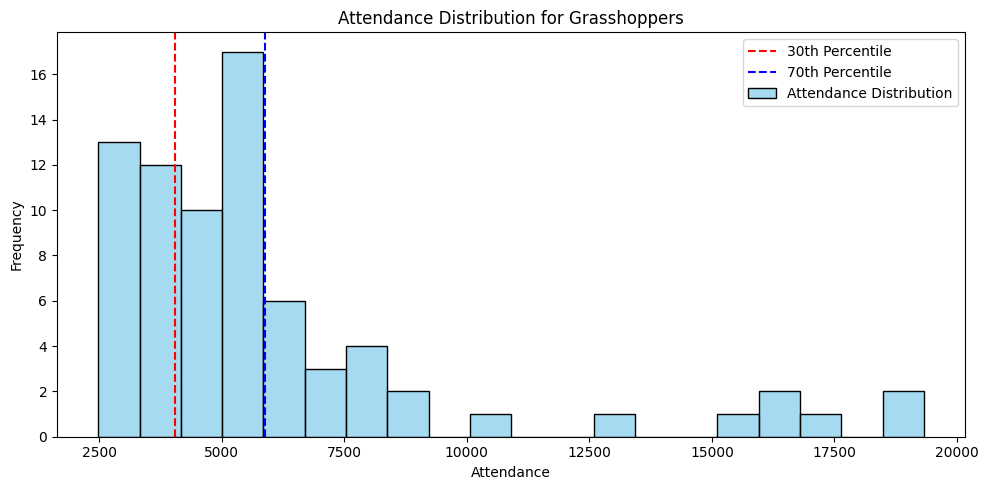

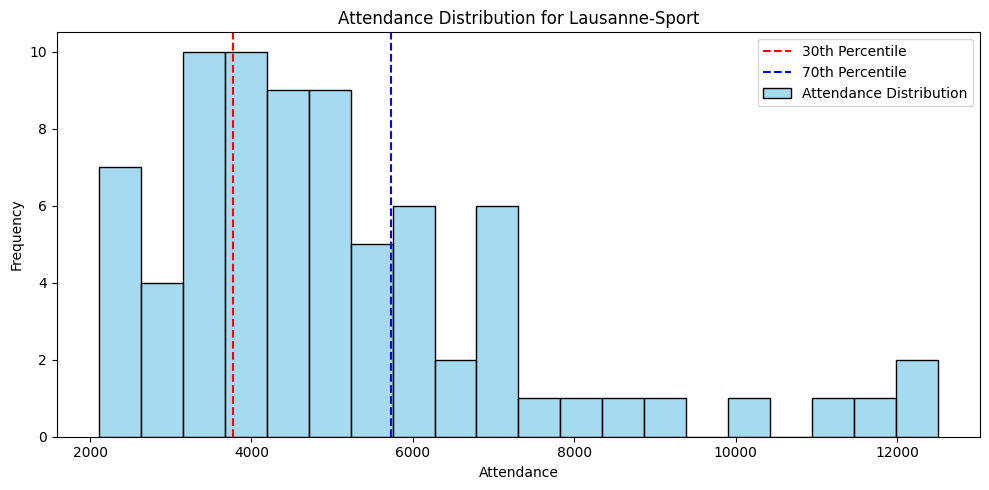

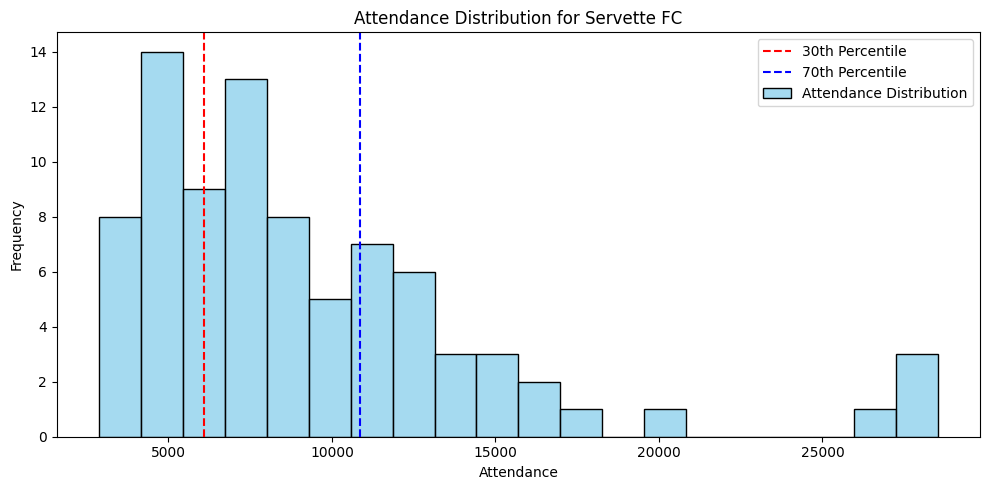

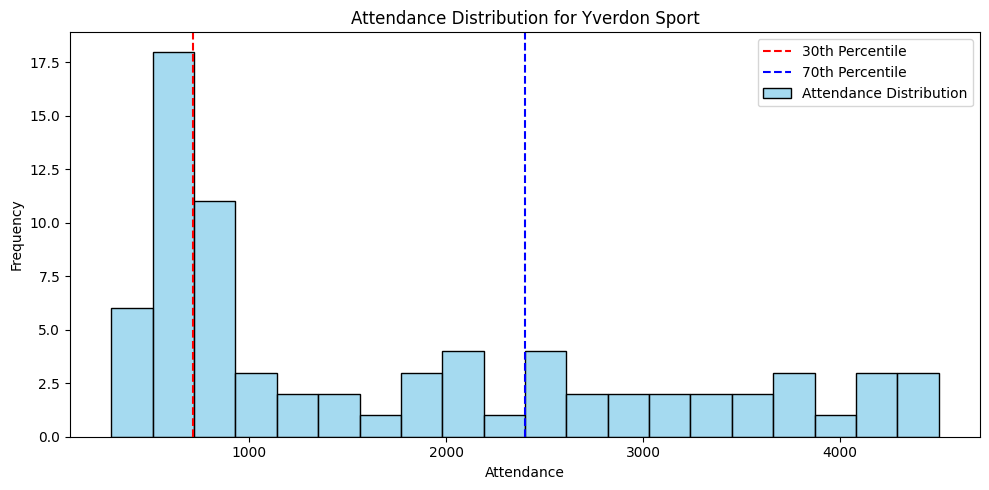

In [9]:
# Iterieren durch jedes Team und die attendance distribution der jeweiligen Teams darstellen
for team in team_stats['Home Team']:
    team_data = df[df['Home Team'] == team]  # Filter data for the specific team
    attendance_30th = team_stats.loc[team_stats['Home Team'] == team, 'attendance_30th_percentile'].values[0]
    attendance_70th = team_stats.loc[team_stats['Home Team'] == team, 'attendance_70th_percentile'].values[0]

    plt.figure(figsize=(10, 5))
    sns.histplot(team_data['Attendance'], kde=False, bins=20, color="skyblue", label="Attendance Distribution")
    plt.axvline(attendance_30th, color='red', linestyle='--', label='30th Percentile')
    plt.axvline(attendance_70th, color='blue', linestyle='--', label='70th Percentile')
    plt.title(f"Attendance Distribution for {team}")
    plt.xlabel("Attendance")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [10]:
#League Table erstellen, um die Tabelle in der App zu visualisieren
data = {
    "Team": [
        "FC Basel", "FC Lugano", "Servette FC", "FC Zürich", "FC Luzern",
        "Lausanne-Sport", "FC St. Gallen", "FC Sion", "BSC Young Boys",
        "Yverdon Sport", "FC Winterthur", "Grasshoppers"
    ],
    "Ranking": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    "Goals_Scored_in_Last_5_Games": [12, 10, 8, 10, 12, 10, 8, 8, 8, 8, 12, 12],
    "Goals_Conceded_in_Last_5_Games": [5, 6, 7, 6, 5, 6, 7, 7, 7, 7, 5, 5],
    "Number_of_Wins_in_Last_5_Games": [3, 2, 1, 1, 2, 3, 1, 2, 3, 0, 1, 0],
    "Last_1_Game_Result": ["Tie", "Lose", "Win", "Tie", "Win", "Tie", "Lose", "Win", "Win", "Lose", "Lose", "Tie"],
    "Last_2_Game_Result": ["Win", "Win", "Lose", "Lose", "Tie", "Win", "Tie", "Lose", "Tie", "Tie", "Tie", "Tie"],
    "Last_3_Game_Result": ["Win", "Lose", "Tie", "Tie", "Lose", "Lose", "Win", "Win", "Win", "Lose", "Win", "Lose"],
    "Last_4_Game_Result": ["Win", "Win", "Lose", "Tie", "Win", "Win", "Tie", "Tie", "Tie", "Lose", "Lose", "Lose"],
    "Last_5_Game_Result": ["Lose", "Tie", "Tie", "Win", "Tie", "Win", "Tie", "Lose", "Win", "Lose", "Tie", "Tie"]
}

# Create the dataframe
league_df = pd.DataFrame(data)

# Save to a CSV file
file_path = 'league_table_combined.csv'
league_df.to_csv(path + file_path, index=False)

### Multikollinearität

Home Team  BSC Young Boys  FC Basel  FC Lugano  FC Luzern  FC Sion  \
Canton                                                               
BE                     94         0          0          0        0   
BS                      0        98          0          0        0   
GE                      0         0          0          0        0   
LU                      0         0          0         78        0   
SG                      0         0          0          0        0   
TI                      0         0         88          0        0   
VD                      0         0          0          0        0   
VS                      0         0          0          0       78   
ZH                      0         0          0          0        0   

Home Team  FC St. Gallen  FC Winterthur  FC Zürich  Grasshoppers  \
Canton                                                             
BE                     0              0          0             0   
BS                     0 

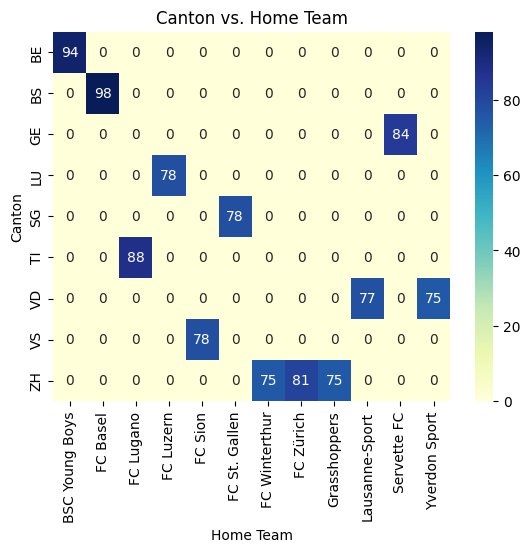

In [11]:
#Zusammenhang zwischen Kanton und Stadion überprüfen
crosstab_home_team = pd.crosstab(df['Canton'], df['Home Team'])

# Ausgabe der Kreuztabelle
print(crosstab_home_team)

# Optional: Visualisierung der Kreuztabelle
sns.heatmap(crosstab_home_team, cmap="YlGnBu", annot=True, fmt="d")
plt.title('Canton vs. Home Team')
plt.xlabel('Home Team')
plt.ylabel('Canton')
plt.show()

Full Roof              0.0  1.0
Stadium                        
Cornaredo Stadium       88    0
Letzigrund               0  156
St. Jakob-Park           0   98
Stade Municipal         75    0
Stade Tourbillon         0   78
Stade de Genève          0   84
Stade de la Tuilière     0   77
Stadion Schützenwiese   75    0
Swissporarena            0   78
Wankdorf Stadium         0   94
kybunpark                0   78


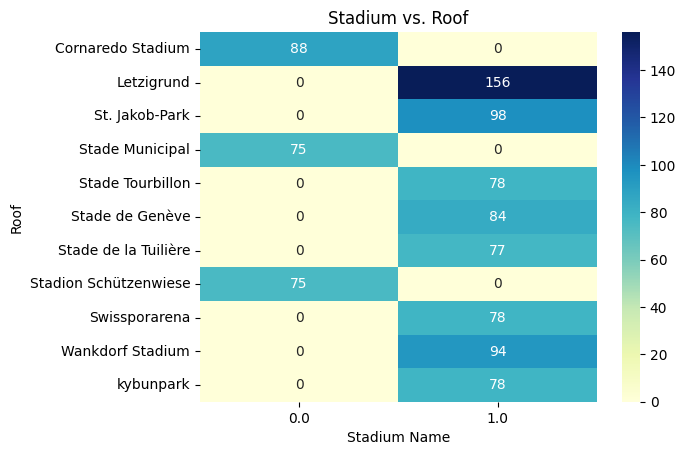

In [12]:
# Zusammenhang zwischen Stadion und Dach prüfen
crosstab_home_team = pd.crosstab(df['Stadium'], df['Full Roof'])

# Ausgabe der Kreuztabelle
print(crosstab_home_team)

# Optional: Visualisierung der Kreuztabelle
sns.heatmap(crosstab_home_team, cmap="YlGnBu", annot=True, fmt="d")
plt.title('Stadium vs. Roof')
plt.xlabel('Stadium Name')
plt.ylabel('Roof')
plt.show()

Stadium         Cornaredo Stadium  Letzigrund  St. Jakob-Park  \
Home Team                                                       
BSC Young Boys                  0           0               0   
FC Basel                        0           0              98   
FC Lugano                      88           0               0   
FC Luzern                       0           0               0   
FC Sion                         0           0               0   
FC St. Gallen                   0           0               0   
FC Winterthur                   0           0               0   
FC Zürich                       0          81               0   
Grasshoppers                    0          75               0   
Lausanne-Sport                  0           0               0   
Servette FC                     0           0               0   
Yverdon Sport                   0           0               0   

Stadium         Stade Municipal  Stade Tourbillon  Stade de Genève  \
Home Team          

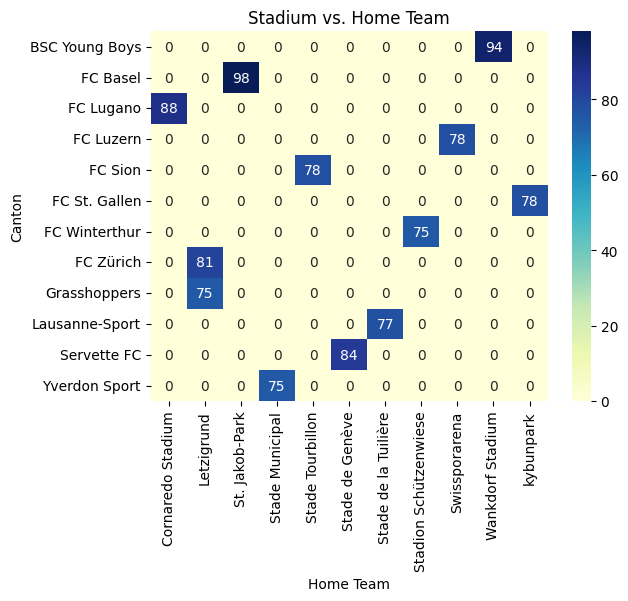

In [13]:
# Zusammenhang zwischen Home Team und Stadion prüfen
crosstab_home_team = pd.crosstab(df['Home Team'], df['Stadium'])

# Ausgabe der Kreuztabelle
print(crosstab_home_team)

# Optional: Visualisierung der Kreuztabelle
sns.heatmap(crosstab_home_team, cmap="YlGnBu", annot=True, fmt="d")
plt.title('Stadium vs. Home Team')
plt.xlabel('Home Team')
plt.ylabel('Canton')
plt.show()

---
**Analyse**

Basierend auf den vorliegenden Heatmaps wird deutlich, dass die Variablen Stadion, Kanton, Stadt, Dachtyp und Home Team stark miteinander korrelieren.


*   **Stadion und Home Team:** Aus der ersten Heatmap geht hervor, dass jedem Stadion genau ein Home Team zugeordnet ist, was bedeutet, dass die Informationen über das Home Team bereits die Zuweisung zum jeweiligen Stadion abdecken.

*  **Stadion und Dachtyp:** In der zweiten Heatmap wird sichtbar, dass Stadien auch mit spezifischen Dachtypen verbunden sind. Da das Stadion wiederum direkt vom Home Team abhängt, sind die Dachinformationen ebenfalls implizit in der Home-Team-Variable enthalten.


*   **Kanton und Home Team:** Die dritte Heatmap zeigt, dass jedes Home Team eindeutig einem Kanton zugeordnet ist. Dies verdeutlicht, dass die Kanton-Information ebenfalls redundant ist, da sie bereits durch die Home-Team-Variable abgedeckt wird.

Angesichts dieser engen Zusammenhänge ist es sinnvoll, Variablen wie Stadion, Kanton, Stadt und Dachtyp aus dem Modell zu entfernen, da alle relevanten Informationen bereits in der Home-Team-Variable enthalten sind. Dies reduziert die Multikollinearität und vereinfacht die Analyse, ohne dass wichtige Informationen verloren gehen.

In [14]:
# Aus unserem ursprünglichen Datenset können viele VAriablen gelöscht werden
df.drop(['Date'], axis=1, inplace=True) # Aufgeteilt in Weekday, Time, Month
df.drop(['Attendance'], axis=1, inplace=True) #Attendance Percentage als Zielvariable
df.drop(['Year'], axis=1, inplace=True)
df.drop(['Season'], axis=1, inplace=True)
df.drop(['quarter'], axis=1, inplace=True) #Bereits in der Variabe Month enthalten
df.drop(['Max Capacity'], axis=1, inplace=True) #Nur relevant um Percentage zu kalkulieren
df.drop(['Full Roof'], axis=1, inplace=True) # In der Variable Stadion und dementsprehcend im Home Team enthalten
df.drop(['Canton_BE'], axis=1, inplace=True) # Kantone sind bereits in der Varable Home Team gespeichert
df.drop(['Canton_BS'], axis=1, inplace=True)
df.drop(['Canton_GE'], axis=1, inplace=True)
df.drop(['Canton_LU'], axis=1, inplace=True)
df.drop(['Canton_SG'], axis=1, inplace=True)
df.drop(['Canton_TI'], axis=1, inplace=True)
df.drop(['Canton_VD'], axis=1, inplace=True)
df.drop(['Canton_VS'], axis=1, inplace=True)
df.drop(['Canton_ZH'], axis=1, inplace=True)
df.drop(['Match Type'], axis=1, inplace=True)
df.drop(['Stadium'], axis=1, inplace=True) # Stadion ist bereits in der Variable Home Team gespeichert
df.drop(['City'], axis=1, inplace=True) # In der VAriable Home Team gespeichert
df.drop(['Canton'], axis=1, inplace=True) # In der Variable Home Team gespeichert
df.drop(['Home Team Outcome'], axis=1, inplace=True) #Variablen der Zukunft
df.drop(['Away Team Outcome'], axis=1, inplace=True) #Variable der Zukunft
df.drop(['Last Month GDP'], axis=1, inplace=True)
df.drop(['Home Team Goals Scored'], axis=1, inplace=True) #Variable der Zukunft
df.drop(['Away Team Goals Scored'], axis=1, inplace=True) #Variable der Zukunft
df.drop(['Holiday'], axis=1, inplace=True)

In [15]:
# Löschen der Zeilen für Promotion League und Super League Barrage
df = df[~df['Competition'].isin(['Promotion League', 'Promotion League - Aufstiegsrunde (bis 21/22)', 'Super League Barrage'])]

df['Competition'] = df['Competition'].replace({
    'UEFA Conference League Qualifiers': 'UEFA Conference League',
    'UEFA Champions League Qualifying': 'UEFA Champions League',
    'UEFA Europa League Qualifying': 'UEFA Europa League'
})

<ipython-input-15-b90a5f66bb49>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Competition'] = df['Competition'].replace({


In [16]:
# Liste der Super League Teams
super_league_teams = [
    'FC Sion', 'FC St. Gallen', 'FC Winterthur', 'FC Zürich',
    'BSC Young Boys', 'FC Luzern', 'Lausanne-Sport', 'Servette FC',
    'FC Basel', 'FC Lugano', 'Grasshoppers', 'Yverdon Sport'
]

# Setze alle anderen Teams auf 'Unknown'
df['Away Team'] = df['Away Team'].apply(lambda team: team if team in super_league_teams else 'Unknown')

<ipython-input-16-7cd0d9993a49>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Away Team'] = df['Away Team'].apply(lambda team: team if team in super_league_teams else 'Unknown')


In [17]:
# Identifiziere die kategorischen Spalten
categorical_columns = [
    "Competition",
    "Matchday",
    "Home Team",
    "Away Team",
    "Weekday"
]

# Dummy-Encoding der kategorischen Spalten
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

In [18]:
# Identifizieren der kategorischen Spalten, wo vollständige Dummy-Codierung angewandt wird,
# damit später leichter Feature Importance analysiert werden kann
categorial_columns_2 = [
    "Opposing team Category",
    "Home team Category",
    "Game day",
    "Time slot",
    "Weather GoodBad",
    "Weather",
]

df_encoded = pd.get_dummies(df_encoded, columns=categorial_columns_2, drop_first=False)

In [19]:
df_encoded = df_encoded.astype(float)

## **Data Exploration**

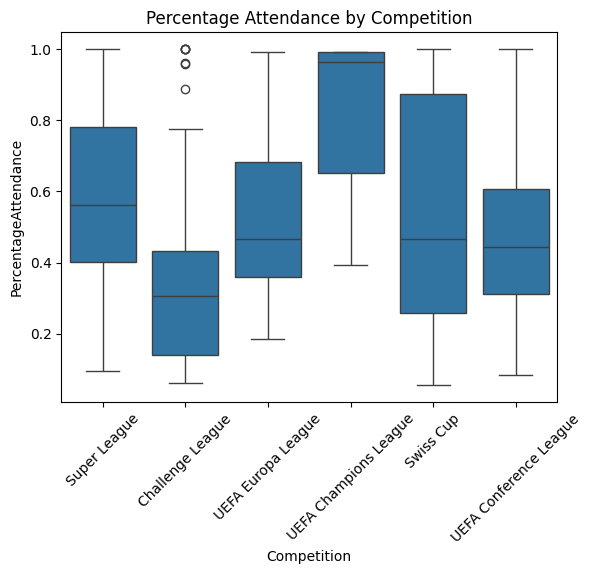

In [20]:
#Einfluss des Wettbewerbs auf die Besucheranzahl
sns.boxplot(x='Competition', y='PercentageAttendance', data=df)
plt.title("Percentage Attendance by Competition")
plt.xticks(rotation=45)
plt.show()

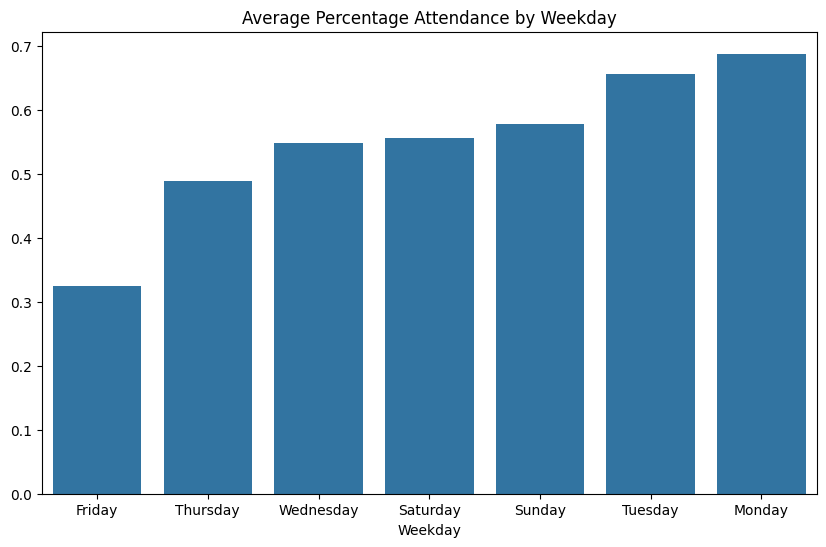

In [21]:
#Einfluss des Wochentages auf die Besucheranzahl
plt.figure(figsize=(10, 6))
mean_attendance = df.groupby('Weekday')['PercentageAttendance'].mean().sort_values()
sns.barplot(x=mean_attendance.index, y=mean_attendance.values)
plt.title("Average Percentage Attendance by Weekday")
plt.show()

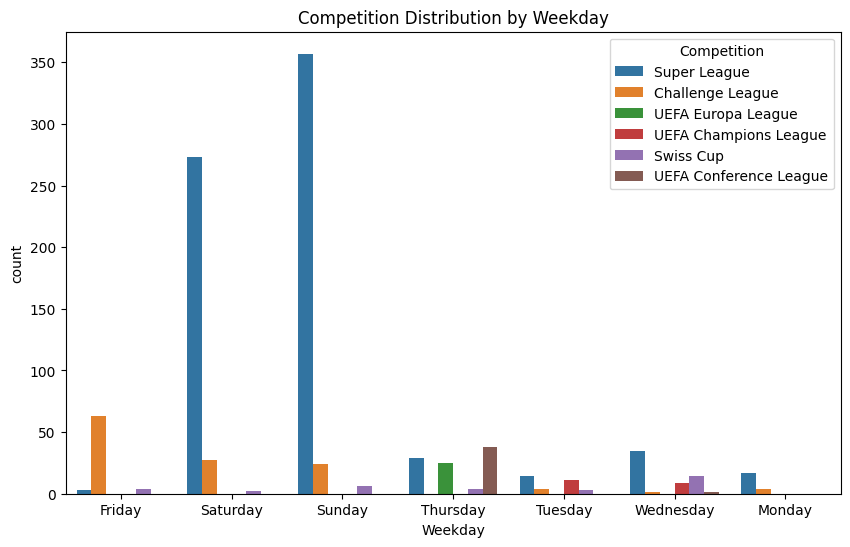

In [22]:
#Wettbewerbe an den jeweiligen Wochentagen
plt.figure(figsize=(10, 6))
sns.countplot(x='Weekday', hue='Competition', data=df)
plt.title("Competition Distribution by Weekday")
plt.show()

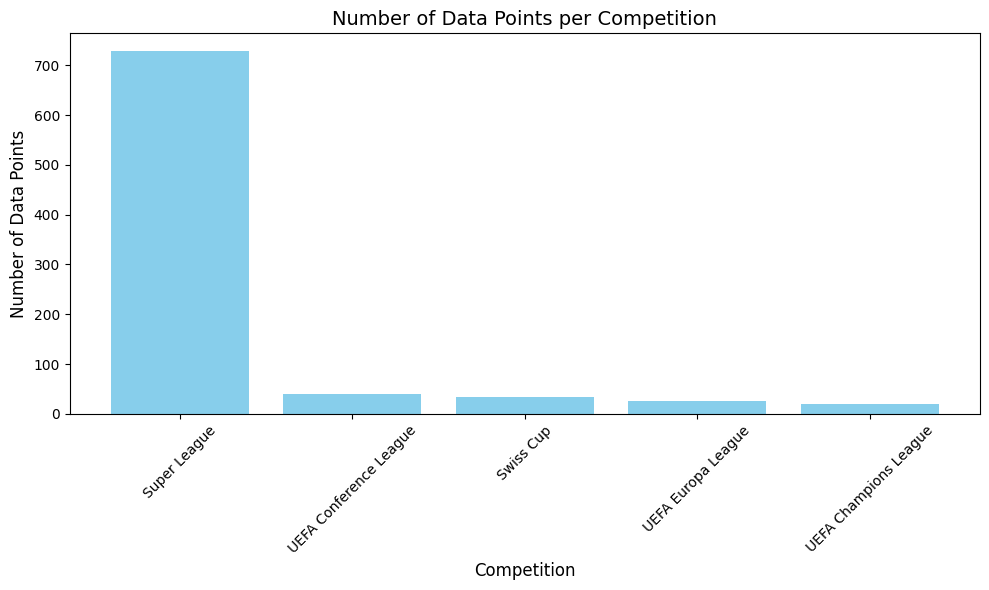

In [23]:
competitions = ['Competition_UEFA Champions League', 'Competition_UEFA Europa League',
                'Competition_Super League', 'Competition_Swiss Cup',
                'Competition_UEFA Conference League']

# Zähle die Anzahl der Datenpunkte für jede Competition
competition_counts = {competition.split('_')[-1]: df_encoded[competition].sum() for competition in competitions}

competition_counts_df = pd.DataFrame(list(competition_counts.items()), columns=['Competition', 'Count'])

# Sortiere nach Anzahl
competition_counts_df = competition_counts_df.sort_values(by='Count', ascending=False)

# Plot erstellen
plt.figure(figsize=(10, 6))
plt.bar(competition_counts_df['Competition'], competition_counts_df['Count'], color='skyblue')
plt.xlabel('Competition', fontsize=12)
plt.ylabel('Number of Data Points', fontsize=12)
plt.title('Number of Data Points per Competition', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()

# Plot anzeigen
plt.show()

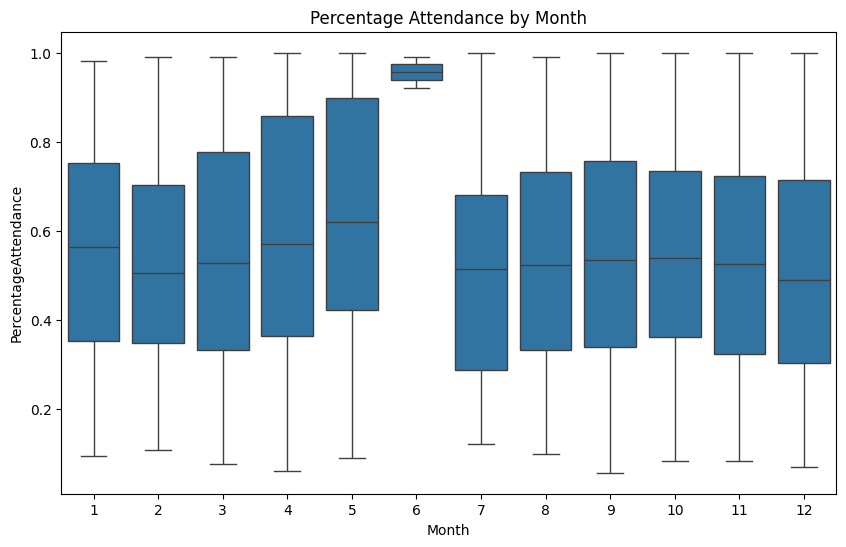

In [24]:
#Einfluss des Monats auf die Besucheranzahl
plt.figure(figsize=(10, 6))
sns.boxplot(x='Month', y='PercentageAttendance', data=df)
plt.title("Percentage Attendance by Month")
plt.show()

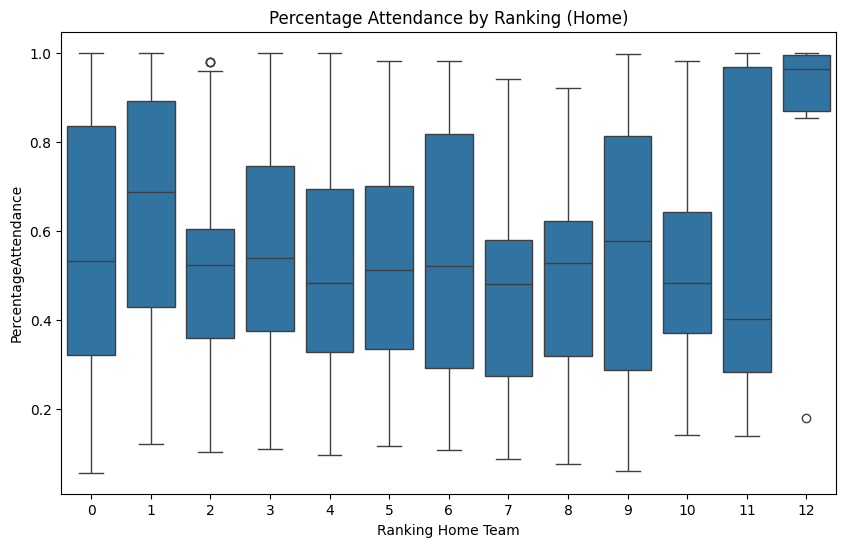

In [25]:
#Einfluss des Home Team Rankings auf die Besucheranzahl
plt.figure(figsize=(10, 6))
sns.boxplot(x='Ranking Home Team', y='PercentageAttendance', data=df)
plt.title("Percentage Attendance by Ranking (Home)")
plt.show()

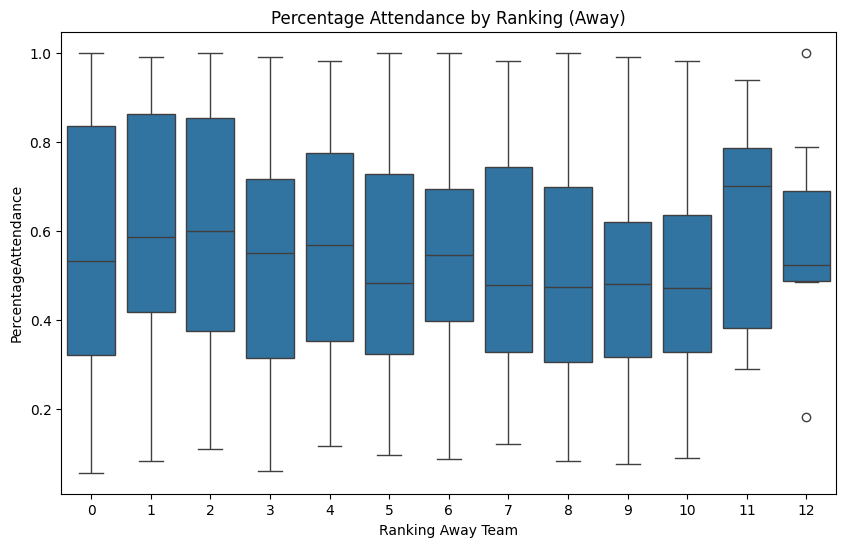

In [26]:
#Einfluss des Away Team Rankings auf die Besucheranzahl
plt.figure(figsize=(10, 6))
sns.boxplot(x='Ranking Away Team', y='PercentageAttendance', data=df)
plt.title("Percentage Attendance by Ranking (Away)")
plt.show()

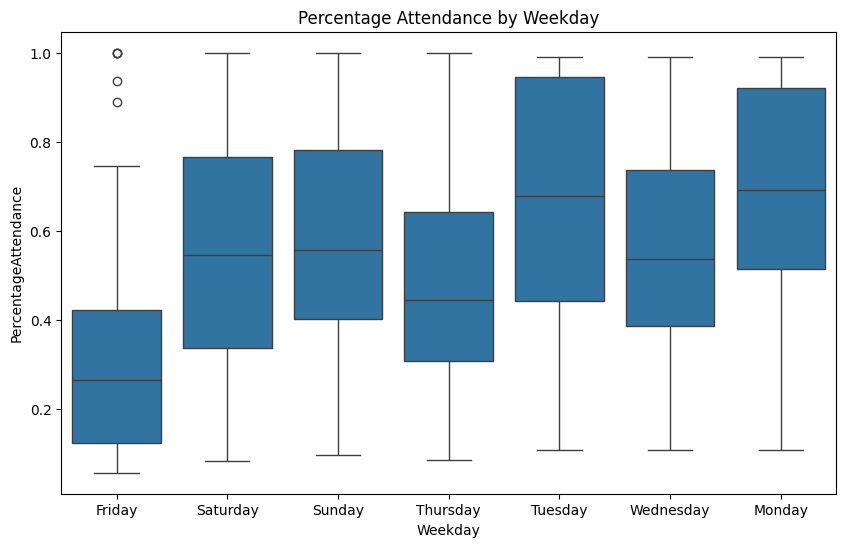

In [27]:
#Einfluss des Wochentages auf die Besucheranzahl
plt.figure(figsize=(10, 6))
sns.boxplot(x='Weekday', y='PercentageAttendance', data=df)
plt.title("Percentage Attendance by Weekday")
plt.show()


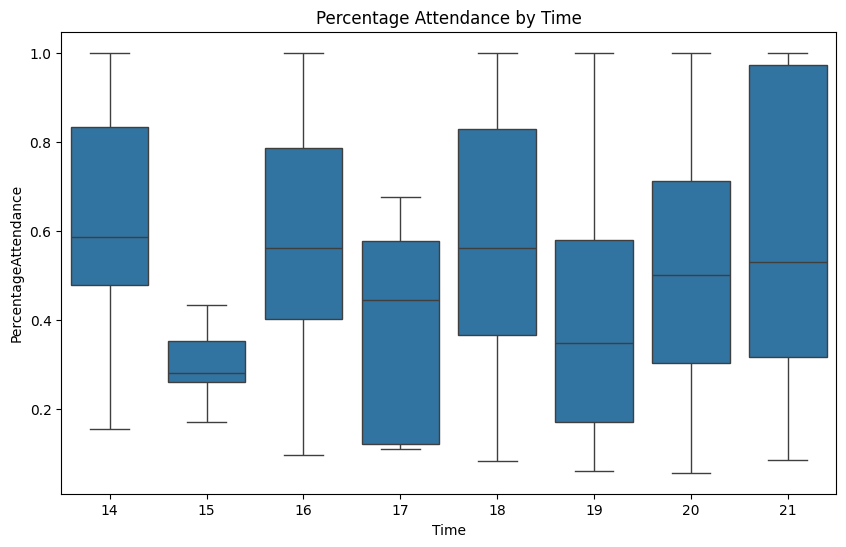

In [28]:
#Einfluss der Uhrzeit auf die Besucheranzahl
plt.figure(figsize=(10, 6))
sns.boxplot(x='Time', y='PercentageAttendance', data=df)
plt.title("Percentage Attendance by Time")
plt.show()

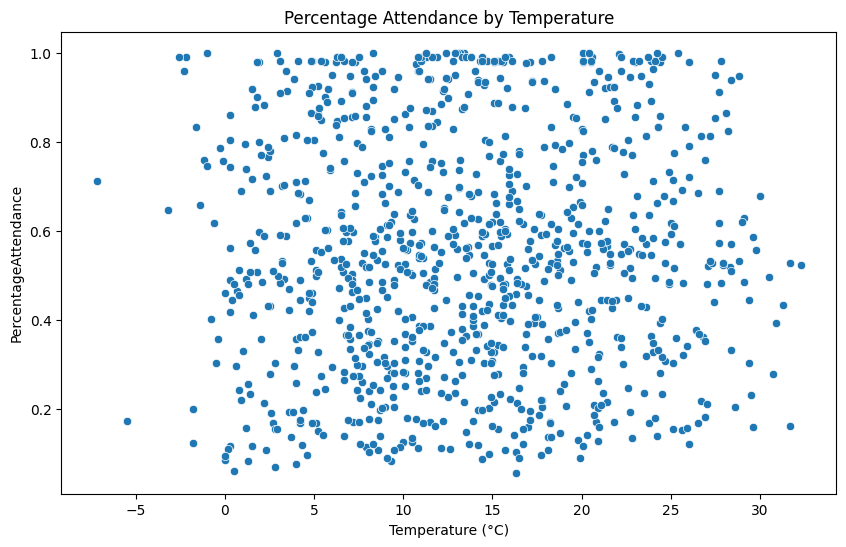

In [29]:
#Einfluss der Temparatur auf die Besucheranzahl
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Temperature (°C)', y='PercentageAttendance', data=df)
plt.title("Percentage Attendance by Temperature")
plt.show()

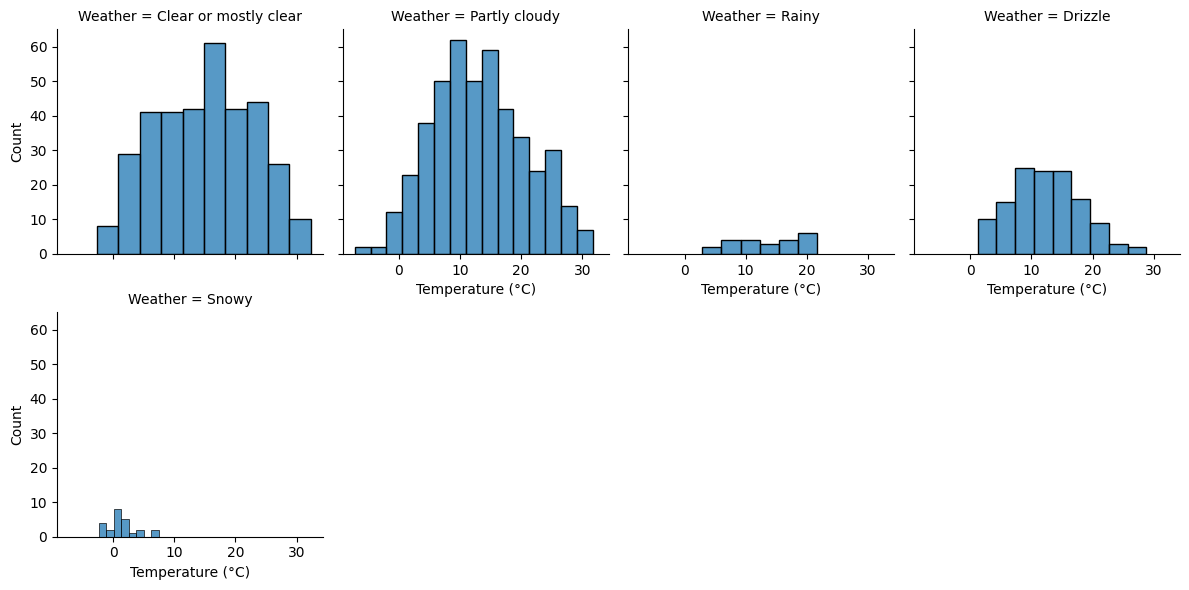

In [30]:
g = sns.FacetGrid(df, col="Weather", col_wrap=4)
g.map(sns.histplot, "Temperature (°C)")
plt.show()

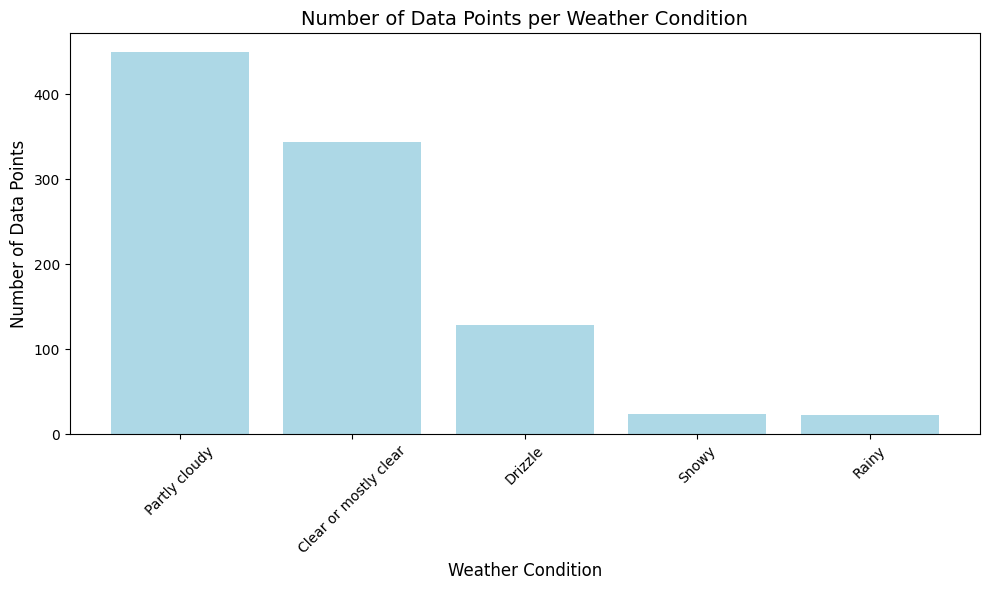

In [31]:
weather_conditions = [ 'Weather_Clear or mostly clear','Weather_Partly cloudy',
                      'Weather_Rainy', 'Weather_Drizzle', 'Weather_Snowy']

# Zähle die Anzahl der Datenpunkte für jede Wetterbedingung
weather_counts = {weather.split('_')[-1]: df_encoded[weather].sum() for weather in weather_conditions}

# Konvertiere zu einem DataFrame für bessere Visualisierung
weather_counts_df = pd.DataFrame(list(weather_counts.items()), columns=['Weather Condition', 'Count'])

# Sortiere nach Anzahl
weather_counts_df = weather_counts_df.sort_values(by='Count', ascending=False)

# Plot erstellen
plt.figure(figsize=(10, 6))
plt.bar(weather_counts_df['Weather Condition'], weather_counts_df['Count'], color='lightblue')
plt.xlabel('Weather Condition', fontsize=12)
plt.ylabel('Number of Data Points', fontsize=12)
plt.title('Number of Data Points per Weather Condition', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()

# Plot anzeigen
plt.show()

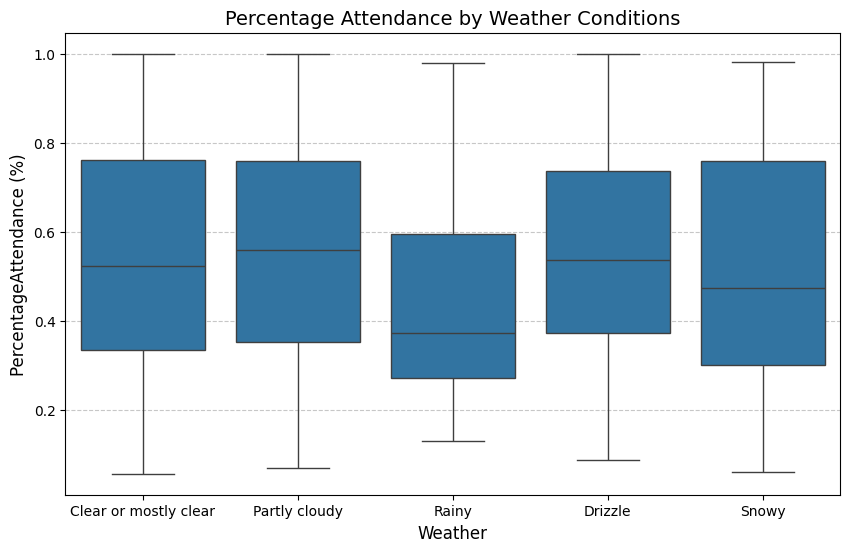

In [32]:
#Einfluss des Wetters auf die Besucheranzahl
plt.figure(figsize=(10, 6))
sns.boxplot(x='Weather', y='PercentageAttendance', data=df)
plt.title('Percentage Attendance by Weather Conditions', fontsize=14)
plt.xlabel('Weather', fontsize=12)
plt.ylabel('PercentageAttendance (%)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

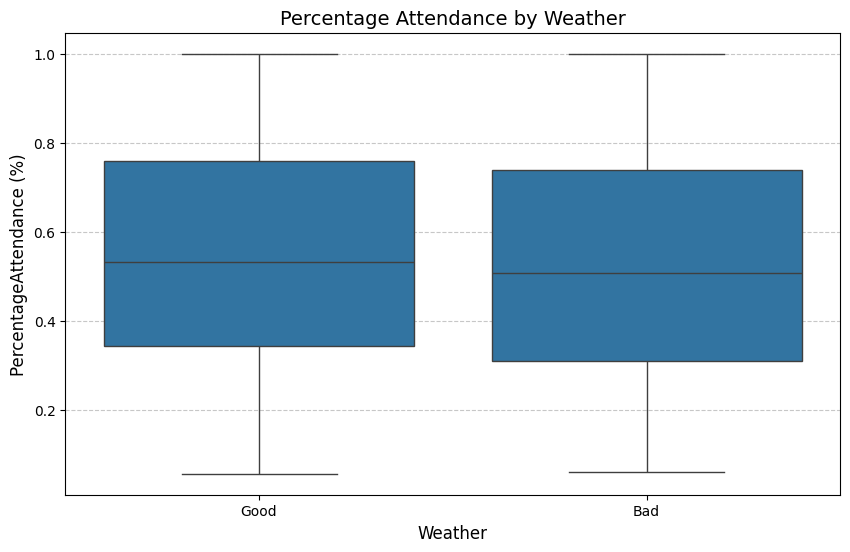

In [33]:
#Einfluss des Wetters auf Besucheranzahl
plt.figure(figsize=(10, 6))
sns.boxplot(x='Weather GoodBad', y='PercentageAttendance', data=df)
plt.title('Percentage Attendance by Weather', fontsize=14)
plt.xlabel('Weather', fontsize=12)
plt.ylabel('PercentageAttendance (%)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

---
**Analyse**

Die Percentage Attendance wird durch mehrere Faktoren beeinflusst, wie die Boxplots zeigen:


*   **Wettbewerb**: Hochkarätige Wettbewerbe wie die Champions League ziehen die höchsten Zuschauerzahlen an, während lokale Ligen wie die Challenge League weniger Interesse wecken.

*   **Monat**: Spiele im Mai, typischerweise Saisonfinale, zeigen die höchste Attendance, während Wintermonate tendenziell geringere Werte aufweisen.

*   **Team-Rankings**: Heim- und Auswärtsteams mit höheren Rankings steigern die Zuschauerzahlen deutlich, während mittlere Rankings weniger Interesse hervorrufen.

*   **Wochentage und Uhrzeit:** Abendspiele und Spiele an Wochenenden haben eine höhere Attendance. Freitags und bei frühen Anstoßzeiten ist die Beteiligung geringer.

*   **Wetterbedingungen**: Gutes Wetter fördert die Attendance, während Regen und Schnee abschreckend wirken.

Insgesamt lässt sich festhalten, dass die Attendance durch Faktoren wie den Wettbewerb, Wetter, Teamranking sowie Uhrzeit und Wochentag beeinflusst wird

## **Model**

In [34]:
# Zielvariable
target = 'PercentageAttendance'

# Spalten, die für das Modell ohne Wetter ausgeschlossen werden sollen
weather_columns = [col for col in df_encoded.columns if col.startswith('Weather_') or col == 'Temperature (°C)']

# Training und Testsplit für das Modell mit Wetter (alle Features)
X_weather = df_encoded.drop(columns=[target])  # Alle Spalten außer der Zielvariable
y_weather = df_encoded[target]
X_train_weather, X_test_weather, y_train_weather, y_test_weather = train_test_split(
    X_weather, y_weather, test_size=0.25, random_state=42
)

# Training und Testsplit für das Modell ohne Wetter (exkludiere Wetterspalten)
X_without_weather = df_encoded.drop(columns=[target] + weather_columns)
y_without_weather = df_encoded[target]
X_train_without_weather, X_test_without_weather, y_train_without_weather, y_test_without_weather = train_test_split(
    X_without_weather, y_without_weather, test_size=0.25, random_state=42
)

In [35]:
#Funktion, die die verschiedenen Metriken in einem Dataframe speichert, um die verschiedenen Modelle
# einfacher zu vergleichen und zu visualisieren

results = pd.DataFrame(columns=["Model", "MSE", "RMSE", "R2"])

def evaluate_model(model_name, y_test, y_pred, results_df):

    mse_value = mean_squared_error(y_test, y_pred)
    rmse_value = np.sqrt(mse_value)
    r2_value = r2_score(y_test, y_pred)

    # Ergebnisse in den DataFrame einfügen
    results_df = pd.concat([
        results_df,
        pd.DataFrame({
            "Model": [model_name],
            "MSE": [mse_value],
            "RMSE": [rmse_value],
            "R2": [r2_value]
        })
    ], ignore_index=True)

    return results_df

### Linear Regression

#### Linear Regression with Weather

In [36]:
#Hinzufügen der Konstante zum Trainingsset
X_train_linreg_weather = sm.add_constant(X_train_weather)

#Modell erstellen und anpassen
linreg_weather = sm.OLS(y_train_weather, X_train_linreg_weather).fit()

In [37]:
#Hinzufügen der Konstante zum Testset
X_test_linreg_weather = sm.add_constant(X_test_weather)

#Vorhersage der Werte
y_pred_linreg_weather = linreg_weather.predict(X_test_linreg_weather)

In [38]:
#Speichern der Ergebnisse im Dataframe
results = evaluate_model("Linear Regression (weather)", y_test_weather, y_pred_linreg_weather, results)

<ipython-input-35-8669de8cd672>:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([


#### Linear Regression without Weather

In [39]:
#Hinzufügen der Konstante zum Trainingsset
X_train_linreg_without_weather = sm.add_constant(X_train_without_weather)

#Modell erstellen und anpassen
linreg_without_weather = sm.OLS(y_train_without_weather, X_train_linreg_without_weather).fit()

In [40]:
#Hinzufügen der Konstante zum Testset
X_test_linreg_without_weather = sm.add_constant(X_test_without_weather)

#Vorhersage der Werte
y_pred_linreg_without_weather = linreg_without_weather.predict(X_test_linreg_without_weather)

In [41]:
#Speichern der Ergebnisse im Dataframe
results = evaluate_model("Linear Regression (without weather)", y_test_without_weather, y_pred_linreg_without_weather, results)

#### Log Linear Regression with Weather

In [42]:
#Log Linear Regression trainieren
log_linreg_weather = sm.OLS(np.log(y_train_weather), X_train_linreg_weather).fit()

#Log linear Regression vorhersagen
y_pred_log_weather = log_linreg_weather.predict(X_test_linreg_weather)

#Normalisieren der log transformierten Vorhersagen
y_pred_log_linreg_weather = np.exp(y_pred_log_weather)

In [43]:
#Speichern der Ergebnisse im Dataframe
results = evaluate_model("Log Linear Regression (weather)", y_test_weather, y_pred_log_linreg_weather, results)

#### Log Linear Regression without weather

In [44]:
#Log Linear Regression trainieren
log_linreg_without_weather = sm.OLS(np.log(y_train_without_weather), X_train_linreg_without_weather).fit()

#Log linear Regression vorhersagen
y_pred_log_without_weather = log_linreg_without_weather.predict(X_test_linreg_without_weather)

#Normalisieren der log transformierten Vorhersagen
y_pred_log_linreg_without_weather = np.exp(y_pred_log_without_weather)

In [45]:
#Speichern der Ergebnisse im Dataframe
results = evaluate_model("Log Linear Regression (without weather)", y_test_without_weather, y_pred_log_linreg_without_weather, results)

###Tree Based Models

#### Random Forest

In [46]:
# Random Forest-Modell mit Wetter
model_with_weather_rf = RandomForestRegressor(
    n_estimators=100,  # Anzahl der Bäume
    max_depth=6,       # Maximale Tiefe der Bäume
    random_state=42    # Zufällige Startnummer für Reproduzierbarkeit
)

# Trainiere das Modell mit Wetter
model_with_weather_rf.fit(X_train_weather, y_train_weather)

# Bewertung des Modells mit Wetter
y_pred_weather_rf = model_with_weather_rf.predict(X_test_weather)

# Random Forest-Modell ohne Wetter
model_without_weather_rf = RandomForestRegressor(
    n_estimators=100,  # Anzahl der Bäume
    max_depth=6,       # Maximale Tiefe der Bäume
    random_state=42    # Zufällige Startnummer für Reproduzierbarkeit
)

# Trainiere das Modell ohne Wetter
model_without_weather_rf.fit(X_train_without_weather, y_train_without_weather)

# Bewertung des Modells ohne Wetter
y_pred_without_weather_rf = model_without_weather_rf.predict(X_test_without_weather)


In [47]:
#Speichern der Ergebnisse im Dataframe
results = evaluate_model("Random Forest (weather)", y_test_weather, y_pred_weather_rf, results)

In [48]:
#Speichern der Ergebnisse im Dataframe
results = evaluate_model("Random Forest (without weather)", y_test_without_weather, y_pred_without_weather_rf, results)

#### XGBoost

In [49]:
# XGBoost-Modell mit Wetter
#Parameter Grid für Hyperparameter Tuning
param_dist = {
    'n_estimators': [500, 700, 900],
    'learning_rate': [0.01, 0.05, 0.1 ],
    'max_depth': [5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bytree': [ 0.4, 0.6, 0.8]
}

model_with_weather_xgb = XGBRegressor(random_state=42)

random_search_weather = RandomizedSearchCV(
    estimator=model_with_weather_xgb,
    param_distributions=param_dist,
    scoring='neg_mean_squared_error',
    n_iter=10,  # Anzahl der getesteten Kombinationen
    cv=3,  # Cross-Validation
    verbose=2,
    random_state=42,
    n_jobs=-1  # Verwende alle verfügbaren Prozessoren
)

# Trainiere das Modell mit Wetter
random_search_weather.fit(X_train_weather, y_train_weather)

best_xgb_weather = random_search_weather.best_estimator_
print("Beste Hyperparameter (Weather):", random_search_weather.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Beste Hyperparameter (Weather): {'subsample': 0.9, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.8}


In [50]:
#Speichern der Ergebnisse im Dataframe
results = evaluate_model("XGBoost (weather)", y_test_weather, best_xgb_weather.predict(X_test_weather), results)

In [51]:
#Parameter Grid für Hyperparameter Tuning
param_dist = {
    'n_estimators': [500, 700, 900],
    'learning_rate': [0.01, 0.05, 0.1 ],
    'max_depth': [5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bytree': [ 0.4, 0.6, 0.8],
}

model_without_weather_xgb = XGBRegressor(random_state=42)

random_search_without_weather = RandomizedSearchCV(
    estimator=model_without_weather_xgb,
    param_distributions=param_dist,
    scoring='neg_mean_squared_error',
    n_iter=10,  # Anzahl der getesteten Kombinationen
    cv=3,  # Cross-Validation
    verbose=2,
    random_state=42,
    n_jobs=-1  # Verwende alle verfügbaren Prozessoren
)

# Trainiere das Modell ohne Wetter
random_search_without_weather.fit(X_train_without_weather, y_train_without_weather)

best_xgb_without_weather = random_search_without_weather.best_estimator_
print("Beste Hyperparameter (Without Weather):", random_search_without_weather.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Beste Hyperparameter (Without Weather): {'subsample': 0.9, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.8}


In [52]:
#Speichern der Ergebnisse im Dataframe
results = evaluate_model("XGBoost (without weather)", y_test_without_weather, best_xgb_without_weather.predict(X_test_without_weather), results)

In [53]:
results

Model       MSE      RMSE        R2
0              Linear Regression (weather)  0.024089  0.155207  0.647675
1      Linear Regression (without weather)  0.023732  0.154053  0.652897
2          Log Linear Regression (weather)  0.028628  0.169199  0.581290
3  Log Linear Regression (without weather)  0.028417  0.168572  0.584385
4                  Random Forest (weather)  0.027494  0.165814  0.597873
5          Random Forest (without weather)  0.027299  0.165225  0.600725
6                        XGBoost (weather)  0.020437  0.142957  0.701099
7                XGBoost (without weather)  0.020023  0.141502  0.707151

---
**Analyse**

Die Modellanalyse zeigt klare Unterschiede in der Vorhersageleistung der verschiedenen Ansätze:

**Lineare Regression:**

*   Die Modelle mit und ohne Wetterdaten liefern solide Ergebnisse.
*   Interessanterweise schneidet die Variante ohne Wetterdaten leicht besser ab (höherer R²-Wert). Dies deutet darauf hin, dass einfache lineare Modelle die zusätzlichen Informationen der Wetterdaten nicht effektiv nutzen können.

**Log-Lineare Regression:**

*   Die Ergebnisse sind ähnlich wie bei der linearen Regression, aber insgesamt etwas schlechter.
*   Dies zeigt, dass eine Log-Transformation der Zielvariable in diesem Fall keine Verbesserung bringt.

**Random Forest:**

*   Die Performance ist insgesamt besser als die der linearen Modelle, sowohl mit als auch ohne Wetterdaten.
*   Auch hier zeigt die Variante ohne Wetterdaten eine leicht bessere Vorhersagegenauigkeit. Random Forest kann nicht-lineare Zusammenhänge besser abbilden, kommt aber nicht an XGBoost heran.

**XGBoost:**

*   XGBoost ist das beste Modell und liefert die höchste Genauigkeit, sowohl mit als auch ohne Wetterdaten.
*   Es zeigt, dass dieses Modell in der Lage ist, komplexe Zusammenhänge zwischen den Variablen zu erfassen. Der Unterschied zwischen den Varianten mit und ohne Wetter ist gering.



In [54]:
# Speichern der Modelle, um diese in Streamlit zu implementieren
filename = 'finalized_model_without_weather.sav'
pickle.dump(model_without_weather_xgb, open(path + filename, 'wb'))

In [55]:
filename = 'finalized_model_with_weather.sav'
pickle.dump(model_with_weather_xgb, open(path + filename, 'wb'))

###Feature Analysis

In [56]:
# SHAP-Werte berechnen
explainer = shap.Explainer(best_xgb_weather, X_train_weather)
shap_values = explainer(X_train_weather)

# SHAP-Werte als DataFrame formatieren
shap_df = pd.DataFrame(shap_values.values, columns=X_train_weather.columns)

# Mapping von Dummy-Features zu Kategorien
categories = {
    'Home team Category': ['Home team Category_Top ranked', 'Home team Category_Medium ranked',
                           'Home team Category_Bottom ranked', 'Home team Category_Not ranked'],
    'Opposing team Category': ['Opposing team Category_Top ranked', 'Opposing team Category_Medium ranked',
                               'Opposing team Category_Bottom ranked', 'Opposing team Category_Not ranked'],
    'Game day': ['Game day_Weekday', 'Game day_Weekend'],
    'Time slot': ['Time slot_Afternoon', 'Time slot_Evening', 'Time slot_Night'],
    'Weather': ['Weather GoodBad_Good', 'Weather GoodBad_Bad'],
    'Competition': ['Competition_UEFA Champions League', 'Competition_Super League', 'Competition_UEFA Europa League', 'Competition_UEFA Conference League'],
}

 99%|===================| 722/726 [00:29<00:00]       

In [57]:
category_shap = []

#Iteriere durch die Kategorien und Subkategorien, um die einzelnen SHAP-Werte zu berechnen
for category, subcategories in categories.items():
    for subcategory in subcategories:
        if subcategory in shap_df.columns:
            # Summiere die absoluten SHAP-Werte
            shap_importance = shap_df[subcategory].sum()
        else:
            shap_importance = 0
        category_shap.append({'Category': category, 'Subcategory': subcategory.split('_')[-1], 'SHAP Importance': shap_importance})

# In DataFrame umwandeln
category_shap_df = pd.DataFrame(category_shap)

In [58]:
formatted_data = []

# Iteriere über die Kategorien
for category, subcategories in categories.items():
    # Füge die Kategorie einmalig hinzu
    first_entry = True
    for subcategory in subcategories:
        # Hole den SHAP-Wert
        shap_importance = category_shap_df.loc[
            (category_shap_df['Category'] == category) &
            (category_shap_df['Subcategory'] == subcategory.split('_')[-1]),
            'SHAP Importance'
        ].sum()

        # Füge die Daten hinzu, wobei die Kategorie nur für die erste Subkategorie angezeigt wird
        formatted_data.append({
            'Category': category if first_entry else '',  # Nur beim ersten Eintrag die Kategorie anzeigen
            'Subcategory': subcategory.split('_')[-1],
            'SHAP Importance': shap_importance
        })
        first_entry = False  # Danach bleibt die Kategorie leer

# Konvertiere die Liste in einen DataFrame
formatted_table_df = pd.DataFrame(formatted_data)
# Ausgabe des DataFrames
formatted_table_df

Category             Subcategory  SHAP Importance
0       Home team Category              Top ranked         0.271626
1                                    Medium ranked         0.441492
2                                    Bottom ranked         0.021923
3                                       Not ranked         0.000000
4   Opposing team Category              Top ranked        -0.002878
5                                    Medium ranked         0.032661
6                                    Bottom ranked        -0.000174
7                                       Not ranked         0.007897
8                 Game day                 Weekday        -0.043431
9                                          Weekend        -0.001726
10               Time slot               Afternoon         0.018851
11                                         Evening        -0.007300
12                                           Night         0.014100
13                 Weather                    Good         0.007930
14                                             Bad         0.078137
15             Competition   UEFA Champions League        -0.733775
16                                    Super League         0.384266
17                              UEFA Europa League         0.000855
18                          UEFA Conference League        -0.072800

---
**Analyse**

Die Analyse der Feature Importance zeigt, dass sowohl interne Faktoren wie die Teamstärke als auch externe Bedingungen wie Wetter und Zeitplanung eine entscheidende Rolle bei der Vorhersage der Stadionauslastung spielen:


*   **Teamkategorien**: Die Stärke des Heimteams (insbesondere mittelstarke und Top-Teams) hat den größten positiven Einfluss auf die Zuschauerbeteiligung. Die Kategorie des Gegners hat hingegen nur einen geringen Einfluss.

*   **Wochentage und Zeit**: Spiele an Wochenenden und am Nachmittag wirken sich leicht positiv aus, während Abendspiele tendenziell weniger gut besucht sind.

*   **Wetter**: Schlechtes Wetter hat den stärksten negativen Einfluss auf die Attendance, während gutes Wetter nur eine geringfügige Auswirkung zeigt.


Insgesamt unterstreichen die Ergebnisse, dass sowohl sportliche als auch externe Faktoren wie Timing und Wetter berücksichtigt werden müssen, um die Zuschauerbeteiligung effektiv vorherzusagen.

### Predicition Analysis

In [59]:
# Erstelle ein DataFrame mit den tatsächlichen und vorhergesagten Werten
results_df = pd.DataFrame({
    'Actual': y_test_without_weather.values,
    'Predicted': best_xgb_weather.predict(X_test_weather)
})

results_df

Actual  Predicted
0    0.917470   0.812873
1    0.084104   0.349413
2    0.161947   0.265646
3    0.979140   0.728989
4    0.869679   0.794888
..        ...        ...
237  0.684676   0.508691
238  0.676984   0.578389
239  0.851166   0.848444
240  0.366407   0.230946
241  0.112121   0.431664

[242 rows x 2 columns]

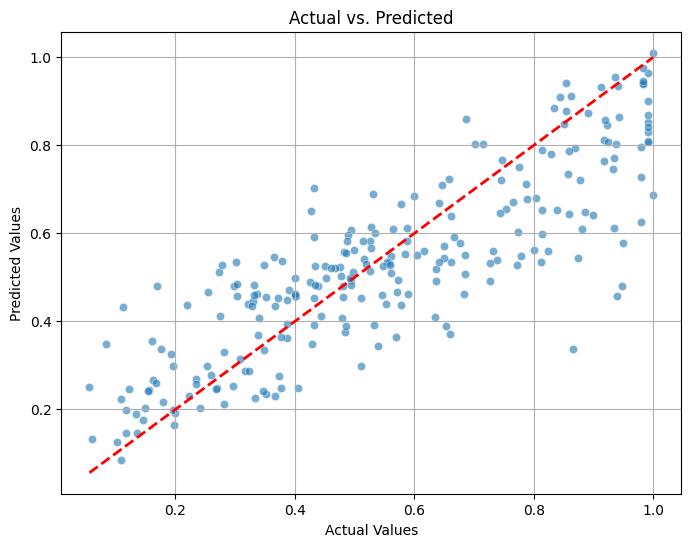

In [60]:
#Visualisiere die Tatsächlichen vs. Vorhergesagten Werte
plt.figure(figsize=(8, 6))
sns.scatterplot(x=results_df['Actual'], y=results_df['Predicted'], alpha=0.6)
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()],
         [results_df['Actual'].min(), results_df['Actual'].max()],
         color='red', linestyle='--', linewidth=2)  # Diagonale Linie
plt.title('Actual vs. Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

---
**Analyse**

**Übereinstimmung mit der Diagonalen:**

*   Die meisten Punkte liegen in der Nähe der roten Linie, was darauf hinweist, dass das Modell die tatsächlichen Werte gut vorhersagt.

*   Besonders im mittleren Bereich (zwischen 0.4 und 0.8) zeigt das Modell eine hohe Genauigkeit.

**Verteilung der Punkte:**

*   Es gibt eine moderate Streuung um die Diagonale, was zeigt, dass das Modell nicht immer perfekt vorhersagt, aber dennoch eine starke Korrelation zwischen tatsächlichen und vorhergesagten Werten besteht.

*   Einige Ausreißer sind erkennbar, vor allem bei sehr niedrigen (unter 0.2) und hohen Werten (über 0.8), wo das Modell weniger präzise ist.

*   Bei  sehr niedrigen Werten tendiert das Modell dazu, die Werte zu überschätzen. Während bei den hohen Werten das Modell die Werte eher unterschätzt.

**Leistung des Modells:**

*   Die diagonale Ausrichtung der Punkte deutet auf ein gut trainiertes Modell hin, das die zugrunde liegenden Muster in den Daten gut erfasst.

*   Die Vorhersagen für den Bereich zwischen 0.2 und 0.8 sind besonders verlässlich, während die Performance bei sehr niedrigen Werten und sehr hohen Werten schlechter ist

In [113]:
average_attendance = df.groupby('Home Team')['PercentageAttendance'].mean().reset_index()

In [114]:
cl_games = df[df['Competition'] == 'UEFA Champions League']

In [115]:
merged_df = cl_games.merge(average_attendance, on='Home Team', how='left')
merged_df = merged_df.rename(columns={
    'PercentageAttendance_x': 'CL Percentage Attendance',  # Spalte für CL-Spiele
    'PercentageAttendance_y': 'Avg Percentage Attendance'  # Spalte für Durchschnitt
})

In [116]:
merged_df[['Home Team', 'CL Percentage Attendance', 'Avg Percentage Attendance', 'Weather']]

Home Team  CL Percentage Attendance  Avg Percentage Attendance  \
0         FC Basel                  0.758621                   0.543646   
1         FC Basel                  0.531523                   0.543646   
2   BSC Young Boys                  0.979140                   0.858099   
3   BSC Young Boys                  0.615549                   0.858099   
4   BSC Young Boys                  0.665293                   0.858099   
5   BSC Young Boys                  0.492465                   0.858099   
6   BSC Young Boys                  0.979140                   0.858099   
7   BSC Young Boys                  0.862033                   0.858099   
8   BSC Young Boys                  0.979140                   0.858099   
9        FC Zürich                  0.392162                   0.514943   
10     Servette FC                  0.599189                   0.311678   
11     Servette FC                  0.864247                   0.311678   
12  BSC Young Boys                  0.991096                   0.858099   
13  BSC Young Boys                  0.991096                   0.858099   
14  BSC Young Boys                  0.991096                   0.858099   
15  BSC Young Boys                  0.991096                   0.858099   
16       FC Lugano                  0.949289                   0.521191   
17  BSC Young Boys                  0.991096                   0.858099   
18  BSC Young Boys                  0.991096                   0.858099   
19  BSC Young Boys                  0.991096                   0.858099   

                  Weather  
0           Partly cloudy  
1                 Drizzle  
2           Partly cloudy  
3   Clear or mostly clear  
4   Clear or mostly clear  
5           Partly cloudy  
6           Partly cloudy  
7   Clear or mostly clear  
8           Partly cloudy  
9           Partly cloudy  
10                  Rainy  
11  Clear or mostly clear  
12          Partly cloudy  
13  Clear or mostly clear  
14                Drizzle  
15          Partly cloudy  
16          Partly cloudy  
17  Clear or mostly clear  
18  Clear or mostly clear  
19          Partly cloudy

---
**Abschliessende Analyse des Modells & Probleme unseres Modells**

*   Ein zentrales Problem unserer Modelle liegt in der begrenzten Anzahl an Datenpunkten. Für viele Stadien gibt es nur wenige bis gar keine Datenpunkte mit verschiedenen Zuschauerzahlen. Dasselbe gilt für bestimmte Features wie Champions League oder Wetterverhältnisse, wo ebenfalls nicht ausreichend Daten vorhanden sind. Mit lediglich 20 Datenpunkten für Champions-League-Spiele und 39 für Europa-League-Spiele ist das Modell nicht in der Lage, diese Verhältnisse korrekt zu interpretieren.

*   **Einfluss von Wettbewerben und Wochentagen:** Die Data Exploration hat klar gezeigt, dass Champions-League- und Europa-League-Spiele tendenziell höhere Attendance-Werte aufweisen. Diese höhere Attendance sollte sich theoretisch auch in den Wochentagen widerspiegeln, da internationale Spiele oft unter der Woche stattfinden. Allerdings wird dieser Effekt durch die Vielzahl an Super-League-Spielen im Datensatz überlagert, die oft eine geringere Attendance aufweisen. Somit ist das Modell nicht in der Lage, die unterschiedlichen Effekte von Wochentagen und Wettbewerben zuverlässig zu trennen. Zudem gibt es wenige Ausnahmen bei Champions-League-Spielen mit geringerer Attendance, bei denen sich jedoch zeigt, dass Wetterbedingungen einen Einfluss haben können.

*   **Wetter als schwach erklärende Variable:** Auch bei den Wetterbedingungen zeigt sich ein Ungleichgewicht: Der Großteil der Datenpunkte repräsentiert gutes Wetter, während Datenpunkte zu schlechtem Wetter spärlich vorhanden sind. Zusätzlich werden diese wenigen Datenpunkte oft durch andere Faktoren wie Derby-Spiele oder internationale Wettbewerbe beeinflusst. Dadurch ist das Modell nicht in der Lage, den isolierten Einfluss von schlechtem Wetter korrekt zu erfassen. Vermutlich hat das Wetter insgesamt auch einen geringeren Einfluss auf die Attendance als ursprünglich angenommen, was sich in der ähnlichen Modellleistung mit und ohne Wetterdaten zeigt:

  - **Ticketkäufe im Voraus:** Die meisten Tickets werden bereits vor dem Spiel erworben, oft ohne genaue Wettervorhersage. Schlechte Wetterbedingungen führen dann nicht zwangsläufig zu einem Nicht-Erscheinen der Fans
  
  - **Stabilität der Fanszene:** Die Kernfans eines Vereins lassen sich durch Wetterbedingungen kaum beeinflussen, wodurch nur ein kleiner Teil der Zuschauer wetterabhängig ist.

*   **Herausforderungen bei der Modellinterpretation:** Die Data Exploration hat gezeigt, dass bestimmte Features (wie Wetter, Wochentag und Uhrzeit) zwar mit der Attendance korrelieren, doch die begrenzte Anzahl an Datenpunkten erschwert es dem Modell, diese Zusammenhänge zuverlässig zu interpretieren. Zusätzlich scheinen einige Features, wie die Uhrzeit oder der Wochentag, einen geringeren Einfluss auf die Attendance zu haben, als ursprünglich vermutet, was sich in ähnlichen Zuschauerzahlen über verschiedene Bedingungen hinweg zeigt.

*   **Modellverhalten bei extremen Werten:** Ein weiterer Schwachpunkt des Modells ist seine Tendenz, Attendance-Werte im unteren Bereich zu überschätzen und im oberen Bereich zu unterschätzen. Dies deutet darauf hin, dass das Modell Schwierigkeiten hat, extreme Werte (wie stark besuchte Champions-League-Spiele oder schwach besuchte Super-League-Spiele) präzise vorherzusagen. Die Ursachen dafür sind:

  - **Widersprüchliche Daten:** Während Champions-League- und Europa-League-Spiele oft hohe Attendance aufweisen, dominieren Super-League-Spiele mit niedriger Attendance unter der Woche. Diese beiden Faktoren sorgen für eine Widersprüchlichkeit in der Daten.
  - **Zu wenige extreme Datenpunkte:** Mit wenigen Datenpunkten für stark besuchte Spiele (z. B. internationale Wettbewerbe) tendiert das Modell dazu, mittlere Werte vorherzusagen, die im Grossteil der Fälle (Super League Spiele) zutreffen.

*    **Fehlende Variablen und externe Faktoren:** Neben den bereits erwähnten Problemen der Variablen gibt es weitere Faktoren, die die Attendance stark beeinflussen, aber nicht im Datensatz berücksichtigt wurden:

  - **Unterschiede zwischen den Fanszenen:** Vereine haben sehr unterschiedliche Fanbasen. Einige Vereine haben traditionell eine hohe Attendance, unabhängig von externen Faktoren wie Wetter oder Wettbewerb. Dies zeigt sich insbesondere bei Vereinen mit einer starken Kern-Fanszene.

  - **Mangelnde Datenpunkte pro Verein:** Mit weniger als 100 Datenpunkten pro Verein lassen sich diese Unterschiede in der Fanbasis nicht modellieren. Um solche Unterschiede zu berücksichtigen, hätten zusätzliche Variablen wie Mitgliederanzahl, Dauerkartenbesitzer oder allgemeine Fanaktivität aufgenommen werden müssen. Alternativ hätte man sich auf einen einzelnen Verein konzentrieren können, um diese internen Unterschiede zu eliminieren.


  ---

  **Zusammenfassung & Handlungsempfehlungen:** Insgesamt liefern die Modelle interessante Erkenntnisse und solide Ergebnisse, stoßen jedoch aufgrund der begrenzten Datenbasis und der fehlenden Berücksichtigung wichtiger Einflussfaktoren an ihre Grenzen. Dies ist hauptsächlich auf eine geringe Datenverfügbarkeit zurückzuführen, besonders aber für extreme Werte und seltene Bedingungen (z. B. Champions-League-Spiele, schlechtes Wetter). Zudem werden wichtige Einflussfaktoren (z.B. Fanszene, Mitgliederanzahl) nicht in unserem Modell berücksichtigt, die wahrscheinlich ebenfalls eine erklärende Rolle für die Attendance spielen sollten.
  
  Für zukünftige Analysen sollte der Fokus daher darauf liegen, die Datenbasis umfassend zu erweitern und zusätzliche erklärende Variablen einzuführen, um die Präzision der Vorhersagen zu erhöhen.
  





